In [107]:
from init_mnist import init, load
import numpy as np

np.random.seed(1)

In [114]:
# in case that dataset is missing or pickle is broken uncomment this
# init()

x_train, y_train, x_test, y_test = load()

# take first 1000 samples
x_train = x_train[0:1000]
y_train = y_train[0:1000]

# transform labels from [2] to [0,0,1,0,0,0,0,0,0,0]
OUT_CLASSES = 10

transformed_y_train = []

for y_label in y_train:
    zero = np.zeros((OUT_CLASSES,))
    zero[y_label] = 1
    transformed_y_train.append(zero)

y_train = transformed_y_train

transformed_y_test = []

for y_label in y_test:
    zero = np.zeros((OUT_CLASSES,))
    zero[y_label] = 1
    transformed_y_test.append(zero)

y_test = transformed_y_test

# normalize input, avoid divergence
x_train = x_train / 255
x_test = x_test / 255

# prepare input for conv layer
x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)

In [115]:
len(x_train[:,0:5,0:5])

1000

In [116]:
a =np.random.rand(10,10)
a[2:5,2:5]

array([[0.12531601, 0.36466024, 0.15318025],
       [0.85370446, 0.19901288, 0.37421261],
       [0.09101587, 0.42983238, 0.34417389]])

In [117]:
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return 1 - (output ** 2)

def softmax(x):
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims=True)

def softmax2deriv(output):
    return output / output.shape[0]

In [144]:
BATCH_SIZE = 128
ALPHA = 2
EPOCHS = 100

INPUT_ROWS = 28
INPUT_COLUMNS = 28

KERNEL_ROWS = 3
KERNEL_COLUMNS = 3
KERNEL_COUNT = 16
OUTPUT_SIZE = 10

NUMBER_OF_SAMPLES_PER_IMAGE = (INPUT_ROWS - KERNEL_ROWS) * (INPUT_COLUMNS - KERNEL_COLUMNS)

# (9, 16)
kernels = 0.02 * np.random.rand(KERNEL_ROWS * KERNEL_COLUMNS, KERNEL_COUNT) - 0.01

# (25*25*16, OUTPUT_SIZE)
weights_1_2 = 0.02 * np.random.rand(NUMBER_OF_SAMPLES_PER_IMAGE * KERNEL_COUNT, OUTPUT_SIZE) - 0.01


def get_sections_from_input(input_data):
    sections = []
    
    for row in range(INPUT_ROWS - KERNEL_ROWS):
        for column in range(INPUT_COLUMNS - KERNEL_COLUMNS):
            section = input_data[:, row:row + KERNEL_ROWS, column:column + KERNEL_COLUMNS]
            
            # extend by one axis for future concatenation
            sections.append(section.reshape(-1,1,KERNEL_ROWS, KERNEL_COLUMNS))
    
    return sections

def predict(input_data, kernels, weights_1_2):
    # list of len 25x25 of (128, 3, 3)
    sections = get_sections_from_input(input_data)
    
    # (625, 128, 3, 3)
    sections_array = np.array(sections)
    
    # reshape to (80 000, 9) 625*128 = 80k
    input_flattened = sections_array.reshape(-1, KERNEL_ROWS * KERNEL_COLUMNS)
    
    # reshape to (128, 25*25*16)
    layer_1 = input_flattened.dot(kernels).reshape(input_data.shape[0], -1)
    layer_1 = tanh(layer_1)
    
    dropout_mask = np.random.randint(2, size=layer_1.shape)
    layer_1 = layer_1 * dropout_mask * 2
    
    layer_2 = layer_1.dot(weights_1_2)
    layer_2 = softmax(layer_2)
    
    return layer_2
    
def accuracy(x_input, y_input, kernels, weights_1_2):
    prediction = predict(x_input, kernels, weights_1_2)
    
    match = 0
    for predicted, label in zip(prediction, y_input):
        if np.argmax(predicted) == np.argmax(label):
            match += 1

    return match / len(prediction)  

def train(x_train, y_train, kernels, weights_1_2):
    for epoch in range(EPOCHS):
        print(f"Epoch: {epoch}")
        for batch_id in range(x_train.shape[0] // BATCH_SIZE):
            batch_index_start = batch_id * BATCH_SIZE
            batch_index_end = batch_index_start + BATCH_SIZE

            # (128, 28, 28)
            x_train_batch = x_train[batch_index_start:batch_index_end]
            y_train_batch = y_train[batch_index_start:batch_index_end]

            # list of len 25x25 of (128, 1, 3, 3)
            sections = get_sections_from_input(x_train_batch)
            
            # concatenate sections by axis=1
            # (128, 625, 3, 3)
            sections_array = np.concatenate(sections, axis=1)

            # reshape to (80 000, 9) 625*128 = 80k
            input_flattened = sections_array.reshape(-1, KERNEL_ROWS * KERNEL_COLUMNS)
            
            # reshape to (128, 25*25*16)
            layer_1 = input_flattened.dot(kernels).reshape(x_train_batch.shape[0], -1)
            layer_1 = tanh(layer_1)

            dropout_mask = np.random.randint(2, size=layer_1.shape)
            layer_1 = layer_1 * dropout_mask * 2

            layer_2 = layer_1.dot(weights_1_2)
            layer_2 = softmax(layer_2)

            # backpropagation
            # BATCH_SIZE because delta is calculated from number of BATCH_SIZE samples
            # (BATCH_SIZE, 10)
            layer_2_delta = softmax2deriv((y_train_batch - layer_2)) / BATCH_SIZE

            # (128, 25*25*16)
            layer_1_delta = layer_2_delta.dot(weights_1_2.T)
            layer_1_delta = layer_1_delta * tanh2deriv(layer_1)
            layer_1_delta *= dropout_mask

            # weighted delta - how much network misses because of wrong weights
            # (25*25*16, OUTPUT_SIZE)
            weighted_delta_1_2 = layer_1.T.dot(layer_2_delta)
            weights_1_2 -= ALPHA * weighted_delta_1_2

            # weighted delta - how much network misses because of wrong weights
            # (9, 80 000) * (80 000, 16)
            weighted_delta_kernels = input_flattened.T.dot(layer_1_delta.reshape(-1, KERNEL_COUNT))
            kernels -= ALPHA * weighted_delta_kernels
   
        print(f"Train acc: {accuracy(x_train, y_train, kernels, weights_1_2)}")
        print(f"Test acc: {accuracy(x_test, y_test, kernels, weights_1_2)}")
        
    return kernels, weights_1_2

In [ ]:
kernels, weights_1_2 = train(x_train, y_train, kernels, weights_1_2)

Epoch: 0
Train acc: 0.092
Test acc: 0.1013
Epoch: 1
Train acc: 0.096
Test acc: 0.1049
Epoch: 2
Train acc: 0.108
Test acc: 0.1051
Epoch: 3
Train acc: 0.097
Test acc: 0.0988
Epoch: 4
Train acc: 0.099
Test acc: 0.1067
Epoch: 5
Train acc: 0.104
Test acc: 0.1035
Epoch: 6
Train acc: 0.109
Test acc: 0.1047
Epoch: 7
Train acc: 0.087
Test acc: 0.1035
Epoch: 8
Train acc: 0.108
Test acc: 0.1045
Epoch: 9
Train acc: 0.094
Test acc: 0.1021
Epoch: 10
Train acc: 0.106
Test acc: 0.1029
Epoch: 11
Train acc: 0.116
Test acc: 0.1095
Epoch: 12
Train acc: 0.116
Test acc: 0.1094
Epoch: 13
Train acc: 0.102
Test acc: 0.1108
Epoch: 14
Train acc: 0.115


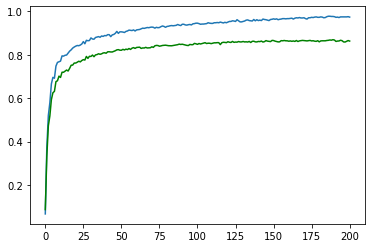

In [43]:
from matplotlib.pyplot import plot

# plot history and see generalization
plot(list(range(len(acc_history))), acc_history, '-')
plot(list(range(len(test_history))), test_history, 'g-')